In [1]:
# Import libs
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

### Prepare data
We are using happy/sad datasets.

In [2]:
# load dataset
X = np.load(r'C:\Users\JHL\F21DL\smiley_X.npy')
y = np.load(r'C:\Users\JHL\F21DL\smiley_y.npy')

In [3]:
# reshape X
print("The original shape of X: ", X.shape)
X = X.reshape((X.shape[0], -1))
print("The shape of X after reshaping: ", X.shape)

The original shape of X:  (144, 9, 9, 1)
The shape of X after reshaping:  (144, 81)


In [4]:
# examine the number of samples in each class
for label in np.unique(y):
    print(f"The number of samples in calss {label}: {sum(y==label)}")

The number of samples in calss 0.0: 72
The number of samples in calss 1.0: 72


In [5]:
# train/test set split
# test set size: 44, train set size: 100 (for 10-fold cross-validation)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=44, random_state=42)
print(X_train.shape)
print(X_test.shape)

(100, 81)
(44, 81)


### Things to do
1. Run a Linear classifier on the training data set, mark the mean squared error (MSE). 
    - What hypothesis can you make about this data set being linearly separable or not?
    - Note also its MSE on the test set. How well does the linear Classifier generalize to new data?
2. Use Logistic regression on your traning set. Then measure the error on the training set. Record all your findings and exlain them.
3. Experiment with various regression parameters that control the learning. For example: the learning rate, the number of iterations and batch size.
4. Put all your results in a suitable form: it can be a table or a series of graphs, that visualize the variations of performance between different settings of the regression algorithm.

### 1. Linear classifier

#### 1-1. The Normal Equation
The normal equations for the multiple regression model are expressed in matrix form as $X^TX \hat \beta = X^Ty$. So $\hat \beta = (X^TX)^{-1}X^Ty$

In [6]:
# add x_0 = 1 to each instance
X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]

In [7]:
det = np.linalg.det(np.dot(X_b.T, X_b))
if det == 0:
    print("The matrix is singular (cannot have an inverse matrix). It cannot be solved by the normal equation.")
else: 
    theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    print(theta_best)

The matrix is singular (cannot have an inverse matrix). It cannot be solved by the normal equation.


#### 1-2. Ordinary Least Squares Linear Regression

In [8]:
from sklearn.linear_model import LinearRegression
# set fit_intercept parameter as False, because we use X_b (1's already added to X_train)
# in this way, results are same as scipy function 
lin_reg = LinearRegression(fit_intercept=False)
lin_reg.fit(X_b, y_train)
print("The number of coefficients (including intercept) are: ", len(lin_reg.coef_))

The number of coefficients (including intercept) are:  82


In [9]:
import scipy
# compare with scipy.linalg.listsq() function
theta_best_svd, residuals, rank, s = scipy.linalg.lstsq(X_b, y_train)
print("The intercept and coefficients calculated by the Linear classifier \
are same as theta_best_svd using scipy listsq function: ", all(theta_best_svd == lin_reg.coef_))

The intercept and coefficients calculated by the Linear classifier are same as theta_best_svd using scipy listsq function:  True


The model's prediction with multiple variables is given by the linear model:

$$ f_{\mathbf{w},b}(\mathbf{x}) =  w_1x_1 + w_2x_2 +... + w_{n}x_{n} + w_0 \tag{1}$$
or in vector notation:
$$ f_{\mathbf{w},b}(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x_b}  \tag{2} $$ 
where $\cdot$ is a vector `dot product` and $\mathbf{x_b}$ is vector $\mathbf{x}$ after added bias 1 (for $w_0$).


In [10]:
# compare classifier's prediction and dot product prediction
# (expected to be same)
y_pred = lin_reg.predict(X_b)
y_pred_dot = np.dot(X_b, lin_reg.coef_)
print("Prediction using classifier predict function and using dot product of X_train and coefficient are same: ", 
     all(y_pred == y_pred_dot))

Prediction using classifier predict function and using dot product of X_train and coefficient are same:  True


#### 1-3. Mark the MSE (Mean Squared Error) - Learning Curve

In [11]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X_train, y_train):
    # split train set into train/cross_validation set
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    # using from 1 to 80 examples, repeat fit-predict and calculate MSE on training and cv sets 
    train_errors, val_errors = [], []
    # set starting number of train size as 2 (to use in logistic classifier too)
    for m in range(2, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    
    # plot errors
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("Root of MSE (Mean Squared Error)", fontsize=14)

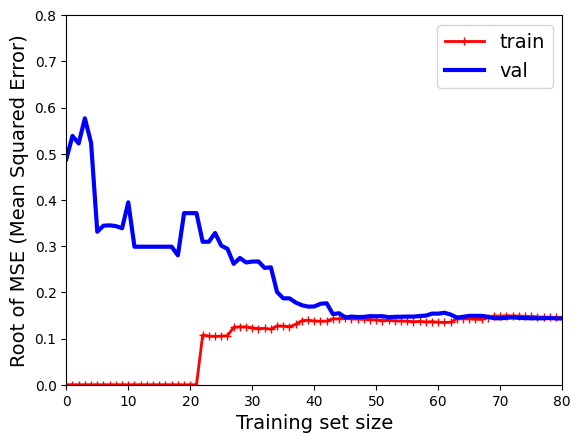

In [12]:
plot_learning_curves(lin_reg, X_train, y_train)
plt.axis([0, 80, 0, 0.8])                         
plt.show()                                      

- **(Q)** What hypothesis can you make about this data set being linearly separable or not?
    - **(A)** It seems that this data can be linearly separable. It has quite low MSE both in train, and test(cross validation) set after the training set size of 45. 
- **(Q)** Note also its MSE on the test set. How well does the linear Classifier generalize to new data?
    - **(A)** The linear classifier generalize well to new data. There is no big difference on between MSEs of train set and MSEs of test set. 

### 2. Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

**Steps for Predicting manually**
1. Compute the prediction from the model $f(x^{(i)}) = g(w \cdot x^{(i)})$ for every example where $w$ is coefficients (including the intercept).
2. From the logistic regression model, use the following heuristic -

  if $f(x^{(i)}) >= 0.5$, predict $y^{(i)}=1$
  
  if $f(x^{(i)}) < 0.5$, predict $y^{(i)}=0$

In [14]:
# predict manually
weights = np.append(log_reg.intercept_, log_reg.coef_)
def sigmoid(z):
    return (1 / (1 + np.exp(-z)))
y_prob = sigmoid(np.dot(X_b, weights))
y_pred_man = y_prob >= 0.5

# predict using classifier predict fuction
y_pred = log_reg.predict(X_train)

# compare
print("Prediction using classifier predict function and by manually are same: ", all(y_pred_man == y_pred))

Prediction using classifier predict function and by manually are same:  True


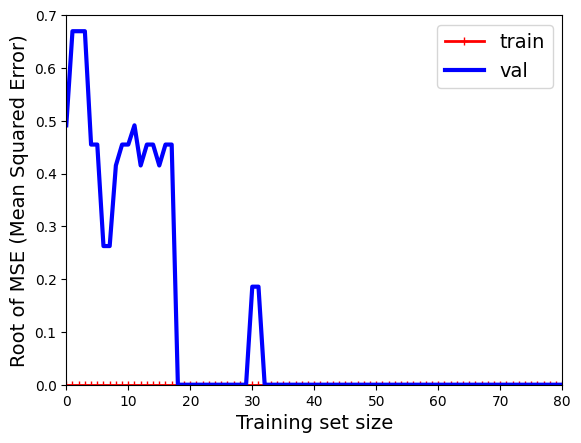

In [15]:
# plot learning curves
plot_learning_curves(log_reg, X_train, y_train)
plt.axis([0, 80, 0, 0.7])                         
plt.show()                                      

- **(Q)** Record all your findings and exlain them.
    - **(A)** The MSE on train set is always 0. The MSE on test set starts to be 0 after the train size of 32. This classifier generalize to new data well.

(100, 1)


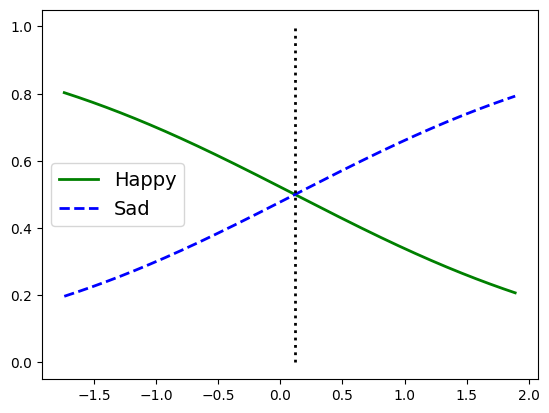

In [16]:
# use pca to make train data 2-dimentional
# for the purpose of decision boundary visualization
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_train, y_train)
print(X_pca.shape)

# train a new classifier 
log_reg_2 = LogisticRegression(solver="lbfgs", random_state=42)
log_reg_2.fit(X_pca, y_train)

# plot probalbity 
X_new = np.linspace(min(X_pca), max(X_pca), 1000).reshape(-1, 1)
y_proba = log_reg_2.predict_proba(X_new)

plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Happy")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Sad")

# plot decision boundary
decision_boundary = X_new[y_proba[:, 0] >= 0.5][0]
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2)
plt.legend(loc="center left", fontsize=14)

### 3. Experiment with various regression parameters that control the learning. 
For example: the learning rate, the number of iterations and batch size.

#### 3-1. Experiment with Linear Regression Parameters

Gradient descent for multiple variables:

$$\begin{align*} \text{repeat}&\text{ until convergence:} \; \lbrace \newline\;
& w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{5}  \; & \text{for j = 0..n-1}\newline
&b\ \ = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b}  \newline \rbrace
\end{align*}$$

where, n is the number of features, parameters $w_j$,  $b$, are updated simultaneously and where  

$$
\begin{align}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{2}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{6}  \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{2}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{7}
\end{align}
$$
* m is the number of training examples in the data set

    
*  $f_{\mathbf{w},b}(\mathbf{x}^{(i)})$ is the model's prediction, while $y^{(i)}$ is the target value


In [17]:
# define a fuction that computes gradient
def compute_gradient(X, y, theta):
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]
    y = y.reshape((m, -1))
    gradients = 2/m * X_b.T.dot(np.dot(X_b, theta) - y)
    return gradients

In [18]:
def plot_graident_descent(X, y, theta, eta, theta_path=None):
    m, n = X.shape
    plt.plot(X, y, "b.")
    X_b = np.c_[np.ones((m, 1)), X]
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 7:
            y_predict = X_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X, y_predict, style)
        gradients = compute_gradient(X, y, theta)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("x_1", fontsize=18)
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

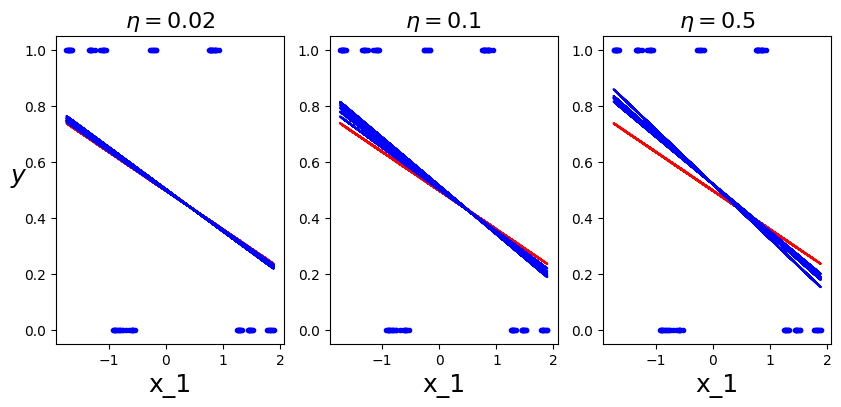

In [19]:
# random initialization
np.random.seed(42)
theta = np.random.randn(2,1)  

# theta_path
theta_path_1 = []
theta_path_2 = []
theta_path_3 = []

# use 2-dimentional X for visualization
plt.figure(figsize=(10,4))
plt.subplot(131); plot_graident_descent(X_pca, y_train, theta, eta=0.02, theta_path=theta_path_1)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_graident_descent(X_pca, y_train, theta, eta=0.1, theta_path=theta_path_2)
plt.subplot(133); plot_graident_descent(X_pca, y_train, theta, eta=0.5, theta_path=theta_path_3)

plt.show()

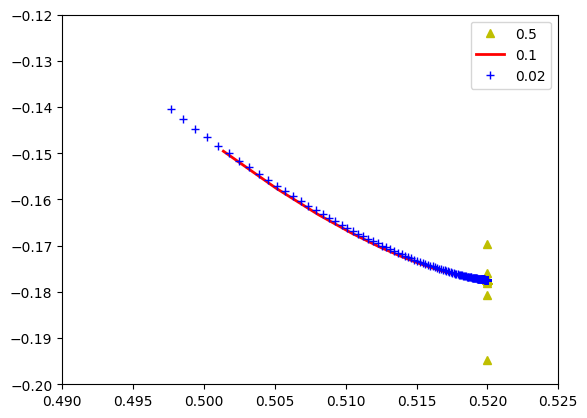

In [20]:
# plot theta path
plt.axis([0.49, 0.525, -.2, -.12])      
plt.plot(np.array(theta_path_3)[:, 0], np.array(theta_path_3)[:, 1], "y^", label="0.5", linewidth=1)
plt.plot(np.array(theta_path_2)[:, 0], np.array(theta_path_2)[:, 1], "r-", label="0.1", linewidth=2)
plt.plot(np.array(theta_path_1)[:, 0], np.array(theta_path_1)[:, 1], "b+", label="0.02", linewidth=3)
plt.legend()

In [21]:
# compare with Classifier's theta
linalg = LinearRegression()
linalg.fit(X_pca, y_train)
optimal = mean_squared_error(y_train, linalg.predict(X_pca))
print(optimal)
print("The coefficent and intercept of the classifier: ", linalg.coef_, linalg.intercept_)
print("The theta after 1000 iteration with eta=0.5   : ", theta_path_3[-1][1], theta_path_3[-1][0])
print("The theta after 1000 iteration with eta=0.1   : ", theta_path_2[-1][1], theta_path_2[-1][0])
print("The theta after 1000 iteration with eta=0.02  : ", theta_path_1[-1][1], theta_path_1[-1][0])

0.20421130686707972
The coefficent and intercept of the classifier:  [-0.17736274] 0.52
The theta after 1000 iteration with eta=0.5   :  [-0.17736274] [0.52]
The theta after 1000 iteration with eta=0.1   :  [-0.17736274] [0.52]
The theta after 1000 iteration with eta=0.02  :  [-0.17736274] [0.52]


In [22]:
def plot_mse_over_iterations(X, y, theta, eta):   
    # set X_b and theta for predicting
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]

    n_iterations = 1000
    errors = []
    for i in range(n_iterations):
        gradients = compute_gradient(X, y, theta)
        theta = theta - eta * gradients
        y_pred = np.dot(X_b, theta)
        error = mean_squared_error(y, y_pred)
        errors.append(error)

    plt.plot(list(range(n_iterations)), errors, label=eta)

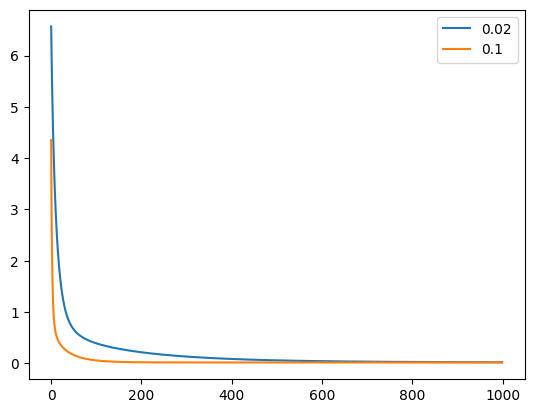

In [23]:
# random initialization
np.random.seed(42)
theta = np.random.randn(82,1)  

plot_mse_over_iterations(X_train, y_train, theta, eta=0.02)
plot_mse_over_iterations(X_train, y_train, theta, eta=0.1)
#plot_mse_over_iterations(X_train, y_train, theta, eta=0.3) results in overflow when calling mse function
plt.legend()

#### 3-2. Experiment with Logistic Regression Parameters

In [24]:
# using sklearn GridSearchCV
from sklearn.model_selection import GridSearchCV

param_distribs = {
     # For small datasets, ‘liblinear’ is a good choice (from the official document)
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [25, 30, 50, 100],
    }

log_clf = LogisticRegression(random_state=42)
grid_search = GridSearchCV(log_clf, param_grid=param_distribs, cv=10, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'max_iter': [25, 30, 50, 100],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [25]:
# result as a dataframe
result = pd.DataFrame(grid_search.cv_results_)
print(result.columns)
result[['params', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values('rank_test_score')

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_iter', 'param_solver', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'split5_test_score', 'split6_test_score',
       'split7_test_score', 'split8_test_score', 'split9_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


,params,mean_test_score,std_test_score,rank_test_score
0,"{'max_iter': 25, 'solver': 'lbfgs'}",1.0,0.0,1
1,"{'max_iter': 25, 'solver': 'liblinear'}",1.0,0.0,1
2,"{'max_iter': 30, 'solver': 'lbfgs'}",1.0,0.0,1
3,"{'max_iter': 30, 'solver': 'liblinear'}",1.0,0.0,1
4,"{'max_iter': 50, 'solver': 'lbfgs'}",1.0,0.0,1
5,"{'max_iter': 50, 'solver': 'liblinear'}",1.0,0.0,1
6,"{'max_iter': 100, 'solver': 'lbfgs'}",1.0,0.0,1
7,"{'max_iter': 100, 'solver': 'liblinear'}",1.0,0.0,1
